In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import sys
print(sys.executable)
sys.path.insert(1, '../src/')
from config import raw_data_path, univariate_data_path, processed_data_path, models_path
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
from FCMAE_model import FCMAE, ConvNeXtBlock1D


/home/nwertheim/miniconda3/bin/python
/home/nwertheim/miniconda3/bin/python


In [2]:
# Set hyperparameters
num_epochs = 10
num_blocks = 5
kernel_size = 9
base_dim = 128
learning_rate = 5.493606514151052e-05
batch_size = 16

In [3]:
train_file = os.path.join(univariate_data_path, 'merged_univariate_train.npy')
train_data = np.load(train_file, allow_pickle=True)
test_file = os.path.join(univariate_data_path, 'merged_univariate_test.npy')
test_data = np.load(test_file, allow_pickle=True)
print(train_data.shape)
print(test_data.shape)

print(train_data[0]['signal'].shape)
print(train_data[0])



(532,)
(134,)
(72200, 1)
{'record_name': 'ice002_p_2of3', 'signal': array([[-12.15116958],
       [-24.48972151],
       [-18.22349939],
       ...,
       [  3.40956282],
       [  1.22642183],
       [  4.90008321]]), 'metadata': {'fs': 20, 'sig_len': 746000, 'n_sig': 16, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV'], 'comments': ['Info:', 'ID:ice002', 'Record type:pregnancy', 'Record number:2/3', 'Age(years):38', 'BMI before pregnancy:20.7', 'BMI at recording:25.9', 'Gravidity:4', 'Parity:1', 'Previous caesarean:No', 'Placental position:Posterior', 'Gestational age at recording(w/d):39/1', 'Gestational age at delivery:40/4', 'Mode of delivery:Vaginal', 'Synthetic oxytocin use in labour:No', 'Epidural during labour:No', 'Comments for recording:', 'Reference on right hip - apparent reverse ECG.', 'Comments for delivery:']}}


In [4]:
import numpy as np
import pandas as pd

# Function to create time windows from the signal data
def create_time_windows(data, window_length=12000, step_size=12000):
    """
    Create sliding windows of a specified length and step size from a list of signals.

    Args:
        data: list of dicts, each containing a 'signal' array of shape (seq_len, 1)
        window_length: number of time steps in each window
        step_size: number of time steps to move between windows (for overlap)

    Returns:
        np.ndarray: shape (num_windows, window_length), univariate windows
    """
    windows = []

    for entry in data:
        signal = entry['signal'].flatten()  # shape: (seq_len,)
        signal_length = len(signal)

        if signal_length < window_length:
            continue

        for start_idx in range(0, signal_length - window_length + 1, step_size):
            end_idx = start_idx + window_length
            window = signal[start_idx:end_idx]
            windows.append(window)

    return np.array(windows)  # shape: (num_windows, window_length)


X_train = create_time_windows(train_data)
X_test = create_time_windows(test_data)
print(X_train.shape)
print(X_test.shape)

(1230, 12000)
(320, 12000)


In [5]:
# import numpy as np
# from sklearn.model_selection import train_test_split

# def split_data(windows, test_size=0.1, val_size=0.1, random_seed=42):
#     """
#     Splits the dataset into training, validation, and test sets with specified proportions.
    
#     Parameters:
#     - windows (numpy.ndarray): The dataset to split, shaped as (num_samples, window_size).
#     - test_size (float): Proportion of data to be used for the test set.
#     - val_size (float): Proportion of data to be used for the validation set.
#     - random_seed (int): Seed for reproducibility.

#     Returns:
#     - X_train, X_val, X_test: The splits of the dataset.
#     """
#     # First, split into train and temp (test + validation)
#     X_train, X_temp = train_test_split(windows, test_size=(test_size + val_size), random_state=random_seed)
    
#     # Then, split the temp into validation and test
#     val_size_adjusted = val_size / (val_size + test_size)  # Adjust to split remaining temp
#     X_val, X_test = train_test_split(X_temp, test_size=val_size_adjusted, random_state=random_seed)
    
#     return X_train, X_val, X_test

# # Example usage with your windows data
# X_train, X_val, X_test = split_data(windows, test_size=0.1, val_size=0.1)

# # Check the shapes of the splits
# print(f"Training set shape: {X_train.shape}")
# print(f"Validation set shape: {X_val.shape}")
# print(f"Test set shape: {X_test.shape}")


In [6]:
def mask_data(x, mask_ratio=0.5, patch_size=8):
    """
    Apply patch-based masking to a batch of univariate time series.

    Args:
        x: np.ndarray of shape (num_windows, window_length)
        mask_ratio: float, fraction of patches to mask
        patch_size: int, number of time steps in each patch

    Returns:
        np.ndarray: masked version of x with same shape
    """
    x_masked = np.copy(x)
    num_windows, window_length = x.shape
    num_patches = window_length // patch_size

    for i in range(num_windows):
        mask = np.random.rand(num_patches) < mask_ratio
        for j in range(num_patches):
            if mask[j]:
                start = j * patch_size
                end = (j + 1) * patch_size
                x_masked[i, start:end] = 0  # or np.nan if you prefer

    return x_masked

# Apply masking to train, validation, and test sets
mask_ratio = 0.75  # Adjust this to your desired masking ratio
masked_X_train = mask_data(X_train, mask_ratio)
masked_X_test = mask_data(X_test, mask_ratio)

# Check the shape of the masked datasets
print(f"Masked Training set shape: {masked_X_train.shape}")
print(f"Masked Test set shape: {masked_X_test.shape}")

Masked Training set shape: (1230, 12000)
Masked Test set shape: (320, 12000)


In [7]:
# import matplotlib.pyplot as plt

# def plot_masked_examples(original, masked, num_examples=5):
#     plt.figure(figsize=(15, num_examples * 2.5))
    
#     for i in range(num_examples):
#         # Original signal
#         plt.subplot(num_examples, 2, 2*i + 1)
#         plt.plot(original[i], color='blue')
#         plt.title(f"Original Signal {i+1}")
#         plt.xlabel("Time step")
#         plt.ylabel("Amplitude")

#         # Masked signal
#         plt.subplot(num_examples, 2, 2*i + 2)
#         plt.plot(masked[i], color='orange')
#         plt.title(f"Masked Signal {i+1}")
#         plt.xlabel("Time step")
#         plt.ylabel("Amplitude")

#     plt.tight_layout()
#     plt.show()
# plot_masked_examples(windows, masked_windows, num_examples=5)


In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

# Define batch size
batch_size = batch_size

# Convert to tensors (still on CPU at this point)
masked_X_train_tensor = torch.tensor(masked_X_train, dtype=torch.float32).unsqueeze(1)
unmasked_X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)

masked_X_test_tensor = torch.tensor(masked_X_test, dtype=torch.float32).unsqueeze(1)
unmasked_X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)

# Create TensorDatasets with both masked and unmasked tensors
train_dataset = TensorDataset(masked_X_train_tensor, unmasked_X_train_tensor)
test_dataset = TensorDataset(masked_X_test_tensor, unmasked_X_test_tensor)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Define model
model = FCMAE(in_channels=1, base_dim=base_dim, num_blocks=num_blocks, kernel_size=kernel_size)

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


FCMAE(
  (encoder): Sequential(
    (0): Conv1d(1, 128, kernel_size=(9,), stride=(2,), padding=(4,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(128, 256, kernel_size=(9,), stride=(2,), padding=(4,))
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(256, 512, kernel_size=(9,), stride=(2,), padding=(4,))
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(512, 1024, kernel_size=(9,), stride=(2,), padding=(4,))
    (10): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv1d(1024, 2048, kernel_size=(9,), stride=(2,), padding=(4,))
    (13): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(2048, 2048, kernel_si

Test Loss: 1.0127
Epoch [1/10], Train Loss: 0.1503
Test Loss: 0.0646
Epoch [2/10], Train Loss: 0.0506
Test Loss: 0.0528
Epoch [3/10], Train Loss: 0.0411
Test Loss: 0.0414
Epoch [4/10], Train Loss: 0.0389
Test Loss: 0.0468
Epoch [5/10], Train Loss: 0.0321
Test Loss: 0.0740
Epoch [6/10], Train Loss: 0.0279
Test Loss: 0.0347
Epoch [7/10], Train Loss: 0.0260
Test Loss: 0.0472
Epoch [8/10], Train Loss: 0.0253
Test Loss: 0.0344
Epoch [9/10], Train Loss: 0.0223
Test Loss: 0.0318
Epoch [10/10], Train Loss: 0.0219


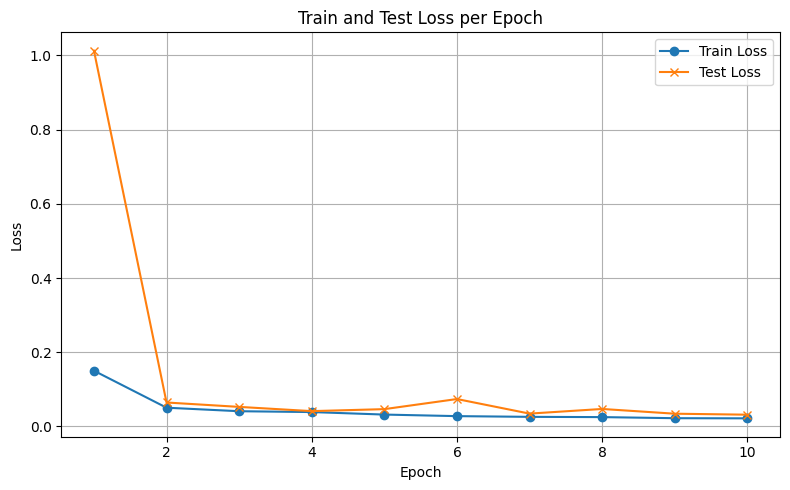

In [9]:
import matplotlib.pyplot as plt

# Set number of epochs
num_epochs = 10

# Lists to store train and test losses for plotting
train_losses = []
test_losses = []

# Training loop
for epoch in range(num_epochs):
    # Testing loop
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_loss = 0.0
        for masked_input, original_input in test_loader:
            # Send data to device (GPU/CPU)
            masked_input = masked_input.to(device)
            original_input = original_input.to(device)

            # Forward pass
            reconstructed = model(masked_input)

            # Compute loss
            loss = criterion(reconstructed, original_input)

            # Update test loss
            test_loss += loss.item()

        # Calculate average test loss for this epoch
        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

    print(f"Test Loss: {avg_test_loss:.4f}")
    
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for masked_input, original_input in train_loader:
        # Send data to device (GPU/CPU)
        masked_input = masked_input.to(device)
        original_input = original_input.to(device)

        # Forward pass
        reconstructed = model(masked_input)

        # Compute loss (compare reconstructed to the original unmasked input)
        loss = criterion(reconstructed, original_input)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

    # Calculate average train loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    

# Plotting after training
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Test Loss per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
# import matplotlib.pyplot as plt

# # Set the model to evaluation mode (no gradient tracking)
# model.eval()

# # Choose a test sample (here, we take the first sample from the test_loader)
# with torch.no_grad():  # Disable gradient calculation for inference
#     # Get a batch from the test loader
#     for batch in test_loader:
#         batch_input = batch[0].to(device)  # Move batch to the device (GPU or CPU)
        
#         # Get the reconstruction from the model
#         output = model(batch_input)

#         # Take the first test sample (index 0)
#         original_sequence = batch_input[0].cpu().numpy().flatten()  # Flatten for easier plotting
#         reconstructed_sequence = output[0].cpu().numpy().flatten()

#         # Plotting the original and reconstructed sequence
#         plt.figure(figsize=(12, 6))
#         plt.plot(original_sequence, label="Original Sequence")
#         plt.plot(reconstructed_sequence, label="Reconstructed Sequence", linestyle='--')
#         plt.legend()
#         plt.title("Original vs Reconstructed Sequence (Test Sample)")
#         plt.xlabel("Time Step")
#         plt.ylabel("Amplitude")
#         plt.show()

#         break  # Only plot for the first test batch (you can modify this if you want to loop through more samples)


In [11]:
# Define the path where you want to save the encoder
path = os.path.join(models_path, 'FCMAE_encoder_cpu_final.pth')

# Save the encoder part of the model
torch.save(model.state_dict(), path)

print(f"Model encoder saved to {path}")

Model encoder saved to ../models/FCMAE_encoder_cpu_final.pth
